In [1]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.set_index('OSEBuildingID', inplace = True)

In [4]:
data

,CouncilDistrictCode,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking(%),PropertyGFABuilding(s)(%),LargestPropertyUseTypeGFA,ENERGYSTARScore,EnergyStarNaN,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(%),Electricity(%),NaturalGas(%),TotalGHGEmissions,GHGEmissionsIntensity,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,7,89,1.0,12,88434,0.000000,100.000000,88434.0,60.0,0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,3.946027e+06,1.276453e+06,249.98,2.83,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,20,1.0,11,103566,14.545314,85.454686,83880.0,61.0,0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,3.242851e+06,5.145082e+06,295.86,2.86,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,47,1.0,41,956110,20.574829,79.425171,756493.0,43.0,0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,4.952666e+07,1.493800e+06,2089.28,2.19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,7,90,1.0,10,61320,0.000000,100.000000,61320.0,56.0,0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,2.768924e+06,1.811213e+06,286.43,4.67,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,7,36,1.0,18,175580,35.311539,64.688461,123445.0,75.0,0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,5.368607e+06,8.803998e+06,505.01,2.88,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50222,2,26,1.0,1,12294,0.000000,100.000000,12294.0,46.0,0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,5.242709e+05,3.254750e+05,20.94,1.70,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
50223,2,12,1.0,1,16000,0.000000,100.000000,16000.0,0.0,1,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.00,3.965461e+05,5.537300e+05,32.17,2.01,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
50224,7,42,1.0,1,13157,0.000000,100.000000,7583.0,0.0,1,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.00,1.792159e+06,3.973739e+06,223.54,16.99,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [5]:
data.loc[data['SourceEUI(kBtu/sf)'].isnull()]

,CouncilDistrictCode,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking(%),PropertyGFABuilding(s)(%),LargestPropertyUseTypeGFA,ENERGYSTARScore,EnergyStarNaN,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(%),Electricity(%),NaturalGas(%),TotalGHGEmissions,GHGEmissionsIntensity,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
773,7,92,1.0,4,63150,0.0,100.0,63150.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
26532,4,88,1.0,2,20760,0.0,100.0,20760.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
data.loc[data['TotalGHGEmissions'].isnull(), 'TotalGHGEmissions'] = np.mean(data['TotalGHGEmissions'])

In [7]:
data.loc[data['GHGEmissionsIntensity'].isnull(), 'GHGEmissionsIntensity'] = np.mean(data['GHGEmissionsIntensity'])

In [8]:
data.loc[data['GHGEmissionsIntensity'].isnull()]

,CouncilDistrictCode,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking(%),PropertyGFABuilding(s)(%),LargestPropertyUseTypeGFA,ENERGYSTARScore,EnergyStarNaN,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(%),Electricity(%),NaturalGas(%),TotalGHGEmissions,GHGEmissionsIntensity,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [9]:
X = data[['CouncilDistrictCode','Age','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','LargestPropertyUseTypeGFA','ENERGYSTARScore','EnergyStarNaN',
        'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Office',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall', 'PrimaryPropertyType_Restaurant',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Senior Care Community',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility']]


y = data['TotalGHGEmissions']

In [10]:
X.shape

(1651, 32)

In [11]:
std_scale = StandardScaler().fit(X)
X_scale = std_scale.transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.25)

In [13]:
X_test.shape

(413, 32)

In [14]:
dr = DummyRegressor(strategy="mean")

In [15]:
dr.fit(X_train, y_train)

DummyRegressor()

In [16]:
baseline_error = np.mean((dr.predict(X_test) - y_test)**2)

In [17]:
baseline_error

131555.38116970676

In [18]:
from sklearn import linear_model

In [19]:
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)

In [20]:
from sklearn.linear_model import Ridge
ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, np.mean((ridge.predict(X_test) - y_test) ** 2)])

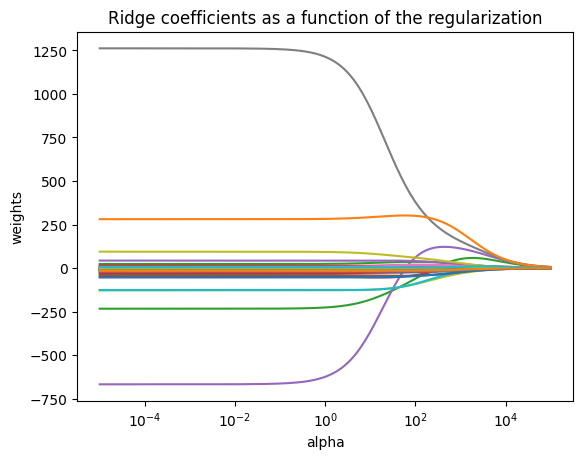

In [21]:
import matplotlib.pyplot as plt

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

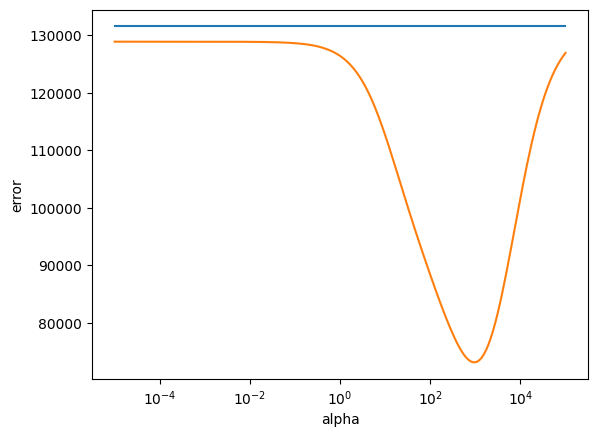

In [22]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [23]:
np.argmin(errors)

319

In [24]:
errors[np.argmin(errors)]

IndexError: list index out of range

In [ ]:
alphas[np.argmin(errors)]